In [ ]:
!pip install river

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 70.3 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [ ]:
import kagglehub
vocal_audio_path = kagglehub.dataset_download('subhajournal/patient-health-detection-using-vocal-audio')

print('Data source import complete.')

Data source import complete.


## Counting Samples of wav files

In [ ]:
import os
#folder = vocal_audio_path+"/patient-vocal-dataset-small/patient-vocal-dataset-small"
folder = vocal_audio_path+"/patient-vocal-dataset/patient-vocal-dataset"
classes = os.listdir(folder)
print(classes)
for cla in classes:
    samp = len([i for i in os.listdir(f'{folder}/{cla}') if i.endswith('.wav')])
    print(f'Detected {samp} samples for class: {cla}')

['Laryngozele', 'Vox senilis', 'Normal']
Detected 84 samples for class: Laryngozele
Detected 392 samples for class: Vox senilis
Detected 560 samples for class: Normal


#Binary classification

In [ ]:
import os
import numpy as np
import librosa
from sklearn.preprocessing import LabelEncoder
from river import metrics, preprocessing, evaluate
from river.forest import ARFClassifier
from river.tree import HoeffdingTreeClassifier
from river.naive_bayes import GaussianNB
from river.linear_model import LogisticRegression

# Path to dataset
data_path = folder

# Load features and labels
X = []
y = []

# Label mapping function
def map_label(label):
    return "health" if label.lower() == "normal" else "unhealth"

def extract_features(file_path):
    audio, sr = librosa.load(file_path, sr=None)

    # MFCCs + deltas
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)
    mfcc_all = np.concatenate((mfcc, delta, delta2), axis=0)
    mfcc_mean = np.mean(mfcc_all.T, axis=0)

    # Additional features
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=audio))
    sc = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sr))
    chroma = np.mean(librosa.feature.chroma_stft(y=audio, sr=sr))

    # Combine all features
    features = np.concatenate([mfcc_mean, [zcr, sc], [chroma]])
    return features

# Load data and extract features
for label in os.listdir(data_path):
    class_path = os.path.join(data_path, label)
    for file in os.listdir(class_path):
        if file.endswith(".wav"):
            file_path = os.path.join(class_path, file)
            features = extract_features(file_path)
            X.append(features)
            y.append(map_label(label))  # Apply binary label mapping

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Initialize model and tools
scaler = preprocessing.StandardScaler()
report = metrics.ClassificationReport()
cm = metrics.ConfusionMatrix()
macro_f1 = metrics.MacroF1()
accuracy = metrics.Accuracy()

# List of adaptive models
models = [
    ("Hoeffding Tree", HoeffdingTreeClassifier()),
    ("Random Forest",ARFClassifier(n_models=10, seed=42)),
    ("Naive Bayes", GaussianNB()),
    ("Logistic Regression", LogisticRegression())
]

# Evaluate each model
for name, base_model in models:
  model = base_model.clone()
  # Online training + monitoring
  for xi, yi in zip(X, y_encoded):
      xi_dict = {f"f{i}": val for i, val in enumerate(xi)}

      scaler.learn_one(xi_dict)
      xi_scaled = scaler.transform_one(xi_dict)

      y_pred = model.predict_one(xi_scaled)

      if y_pred is not None:
          y_true_label = le.inverse_transform([yi])[0]
          y_pred_label = le.inverse_transform([y_pred])[0]

          report.update(y_true_label, y_pred_label)
          cm.update(y_true_label, y_pred_label)
          macro_f1.update(yi, y_pred)
          accuracy.update(yi, y_pred)

      model.learn_one(xi_scaled, yi)
  print(name+" Results:")
  # Output results
  print("\n🧾 Final Classification Report:\n")
  print(report)

  print("\n📊 Confusion Matrix:\n")
  print(cm)

  print(f"\n✅ Accuracy: {accuracy.get():.2%}")
  print(f"📏 Macro F1 Score: {macro_f1.get():.4f}")

/usr/local/lib/python3.11/dist-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Hoeffding Tree Results:

🧾 Final Classification Report:

           Precision   Recall    F1       Support  
                                                   
  health     100.00%    78.39%   87.89%       560  
unhealth      79.70%   100.00%   88.70%       475  
                                                   
   Macro      89.85%    89.20%   88.30%            
   Micro      88.31%    88.31%   88.31%            
Weighted      90.68%    88.31%   88.26%            

                  88.31% accuracy                  

📊 Confusion Matrix:

           health   unhealth  
  health      439        121  
unhealth        0        475  

✅ Accuracy: 88.31%
📏 Macro F1 Score: 0.8830
Random Forest Results:

🧾 Final Classification Report:

           Precision   Recall    F1       Support  
                                                   
  health     100.00%    87.95%   93.59%      1120  
unhealth      87.56%   100.00%   93.37%       950  
                                                  

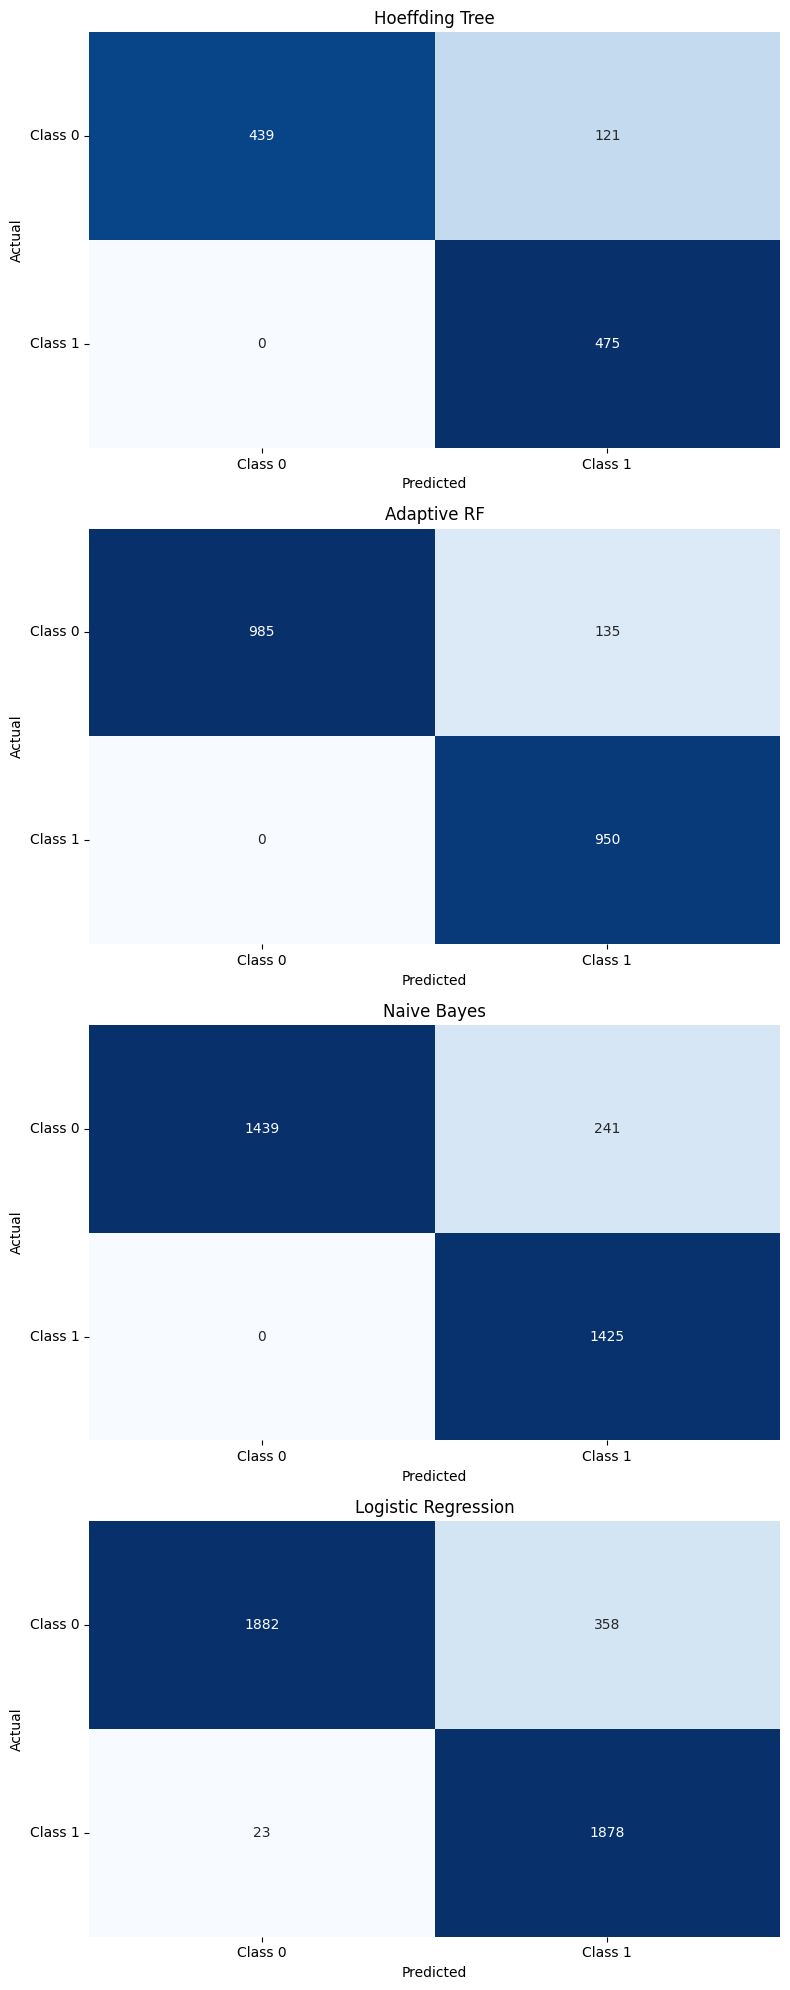

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the confusion matrices
conf_matrices = {
    "Hoeffding Tree": np.array([[439, 121],
                                [0, 475]]),
    "Adaptive RF": np.array([[985, 135],
                             [0, 950]]),
    "Naive Bayes": np.array([[1439, 241],
                             [0, 1425]]),
    "Logistic Regression": np.array([[1882, 358],
                                     [23, 1878]])
}

# Set up a vertical sequence of plots (4 rows, 1 column)
fig, axes = plt.subplots(1, 4, figsize=(8, 20))  # Taller figure for vertical layout

# Plot each confusion matrix vertically
for ax, (title, matrix) in zip(axes, conf_matrices.items()):
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_xticklabels(['Class 0', 'Class 1'])
    ax.set_yticklabels(['Class 0', 'Class 1'], rotation=0)

plt.tight_layout()
plt.show()